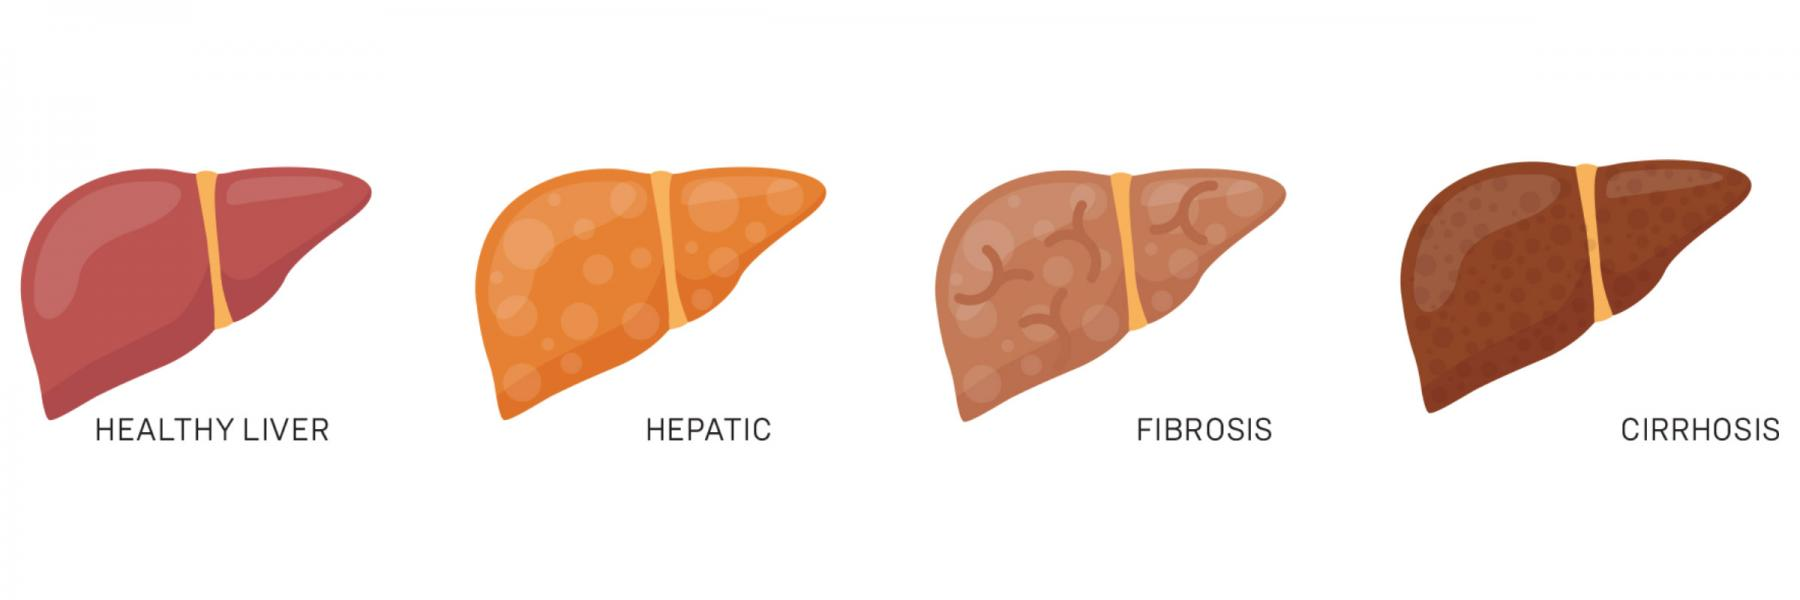

## 1. Introduction

### 1. 1 Aim

In this project, we created a binary classification model to predict the 5-year survival rate of patients with liver cancer. The models were trained on the Hepatocellular Carcinoma (HCC) dataset, using a combination of deep learning and traditional machine learning algorithms. Model accuracies were compared and the optimal algorithm and hyperparameters were selected for the classification problem.

### 1.2 Background

Hepatocellular carcinomas are one of the world's most common malignancies, with more than 750,000 new cases each year. They rank third amongst mortality rates of all cancers. Hepatocellular carcinomas often occur in the chronically inflamed liver and is often associated with chronic viral hepatitis infection (hepatitis B or C), or exposure to toxins such as alcohol or aflatoxin. Certain diseases such as hemochromatosis and alpha 1-antitrypsin deficiency markedly increase the risk of developing HCC. Metabolic syndrome and non-alcoholic fatty liver disease (NASH) are also increasingly recognized as risk factors for HCC.

### 1.3 Data

"*The HCC dataset was obtained at a University Hospital in Portugal and contains several demographic, risk factors, laboratory and overall survival features of 204 real patients diagnosed with HCC. The dataset contains 49 features selected according to the EASL-EORTC (European Association for the Study of the Liver - European Organisation for Research and Treatment of Cancer) Clinical Practice Guidelines, which are the current state-of-the-art on the management of HCC.*

*This is an heterogeneous dataset. A detailed description of the HCC dataset is provided in [Santos et al](https://www.sciencedirect.com/science/article/pii/S1532046415002063).*"

## 2. Exploratory data analysis

Before any feature selection or modelling we investigate our data. We will check data for completeless and  investigate variable distributions. We can then decide which feature engineering approaches will be appropriate to apply to our data.

### 2.1 Data evaluation

Let's load the dataset into pandas:

In [17]:
#import modules
import pandas as pd

#view data
df = pd.read_csv("D:\DSProjects\Data_Science\Quick Projects\HCC\hcc-data-complete-balanced.csv", decimal=",")
df.head()

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,...,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
0,1,0,1,0,0,0,0,1,0,1,...,150,7.1,0.70,1,3.5,0.50,52.5,37.0,856.0,1
1,0,0,0,0,0,0,1,1,0,1,...,120,7.0,0.58,1,1.8,0.85,32.0,10.0,18.0,1
2,1,0,1,1,0,1,0,1,0,1,...,109,7.0,2.10,5,13.0,0.10,28.0,6.0,16.0,1
3,1,1,1,0,0,0,0,1,0,1,...,174,8.1,1.11,2,15.7,0.20,131.0,78.0,1316.0,0
4,1,1,1,1,0,1,0,1,0,1,...,109,6.9,1.80,1,9.0,0.10,59.0,15.0,22.0,1


We are using the 'hcc-data-complete-balanced' dataset, which allegedly has no null values; let's check whether that is the case. We will also asses the dataframe shape:

In [18]:
#shows whether df has any null values
print("Null values present:", df.isnull().values.any())

#assess dataframe size and shape 
print("Data shape         :", df.shape)

Null values present: False
Data shape         : (204, 50)


We can see there are 204 patients each with 50 variables. There is no missing data and no imputation/removal will be required before we start feature selection.

### 2.2 Data exploration

An accompanying text file describes four data types for the HCC dataset: Binary, continuous, integer, and ordinal. Let's split our variables based on the listed data types:

In [19]:
#asessing feature data types
binary = ['Gender', 'Symptoms', 'Alcohol', 'HBsAg', 'HBeAg', 'HBcAb', 'HCVAb', 'Cirrhosis', 'Endemic', 'Smoking', 'Diabetes', 'Obesity', 'Hemochro', 'AHT','CRI','HIV','NASH','Varices','Spleno','PHT','PVT','Metastasis','Hallmark']
continuous = ['Grams_day','Packs_year','INR','AFP','Hemoglobin','MCV','Leucocytes','Platelets','Albumin','Total_Bil','ALT','AST','GGT','ALP','TP','Creatinine','Major_Dim','Dir_Bil','Iron','Sat','Ferritin']
integer = ['Age','Nodule']
ordinal = ['PS','Encephalopathy','Ascites']

#extract list of numerical variables
binary_df = df[binary]
continuous_df = df[continuous]
integer_df = df[integer]
ordinal_df = df[ordinal]

#show data type counts
print("Number of binary variables:     ",len(binary)+1) #to include target variables "Class"
print("Number of continuous variables: ",len(continuous))
print("Number of integer variables:    ",len(integer))
print("Number of ordinal variables:    ",len(ordinal))

Number of binary variables:      24
Number of continuous variables:  21
Number of integer variables:     2
Number of ordinal variables:     3


The dataset is mostly comprised of binary and continuous variables types, making up 48% and 42% of the total variables in our dataset.

**Binary data**

Let's view the distributions of binary features. I have removed the binary target variable `class` as we will visualize it separately:

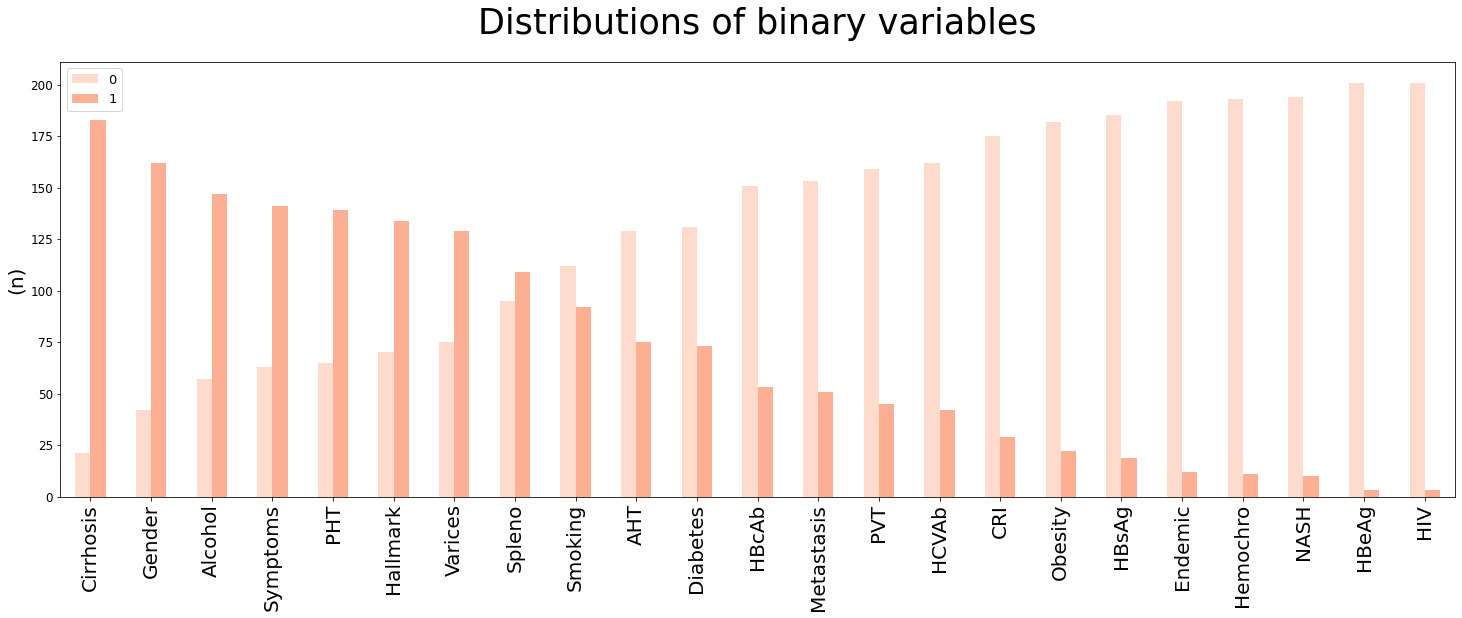

In [20]:
#import modules
import seaborn as sns
import matplotlib.pyplot as plt

#set seaborn style
sns.set_palette('Reds')

#get value counts for binary data
binary_counts = []
for col in binary_df.columns.tolist():
    binary_counts.append(binary_df[col].value_counts())
binary_counts = pd.DataFrame(binary_counts).sort_values(by = [0])

#plot graph  
binary_counts.plot.bar(figsize=(25,8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.ylabel("(n)", fontsize = 20)
plt.title('Distributions of binary variables', fontsize = 35, y = 1.05, x = 0.5)
plt.legend(fontsize = 13)

#show plot
plt.show()

Binary variables have heterogeneous distribution profiles. Highly skewed variables such as `HIV`, `HBeAg`, and `Hemochro` have very few positive values. It is important to consider skews when building our model, as small sample sizes can have a large influence on classification models. This could lead to a model which shows a bias that is unrepresentative of out-of-sample data.

**Ordinal variables**

Our dataset contains 3 Ordinal variables: Performance Status (PS), Encephalopathy, Ascites. Each variable is ranked in ascending order of severity. Let's view the distributions of ordinal variables:

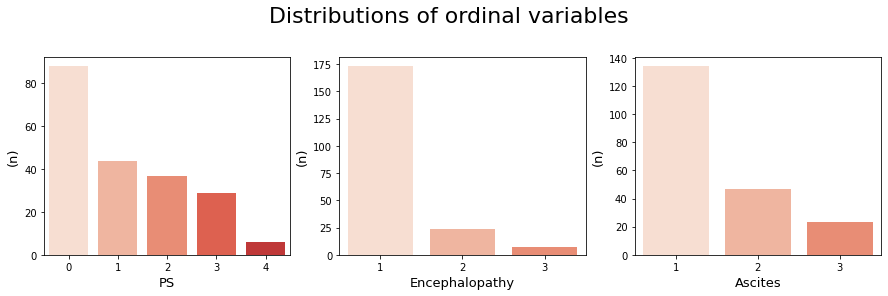

In [21]:
#create plot area
plt.figure(figsize = (15,2))
plt.subplots_adjust(top = 1.5)
plt.suptitle('Distributions of ordinal variables', y  = 1.85, fontsize = 22)

#loop through subplots
for index, col in enumerate(ordinal_df.columns.tolist()):
    plt.subplot(1,3,index+1)
    sns.countplot(x = ordinal_df[col]).set_ylabel('')
    plt.ylabel("(n)", fontsize = 13)
    plt.xlabel(col, fontsize = 13)
    
#show plot
plt.show()

There is an inverse relationship between the frequency of variable levels and severity across all three oridnal variables. This is most pronounced in `encephalopathy` where there is a steep decline in frequency between levels 1 and 2, followed by a smaller drop between levels 2 and 3.

**Continuous variables**

The continuous variables have differing data ranges. We will need to scale the variables to compare distributions on a boxplot chart. [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) transforms variables to create scaled values between 0 -1 and tolerates outliers. We want to see the distribution outliers in our chart as they can be important data points. Let's scale our variables using sklearn's MinMaxScaler and visualize the distributions using seaborn's boxplot function:

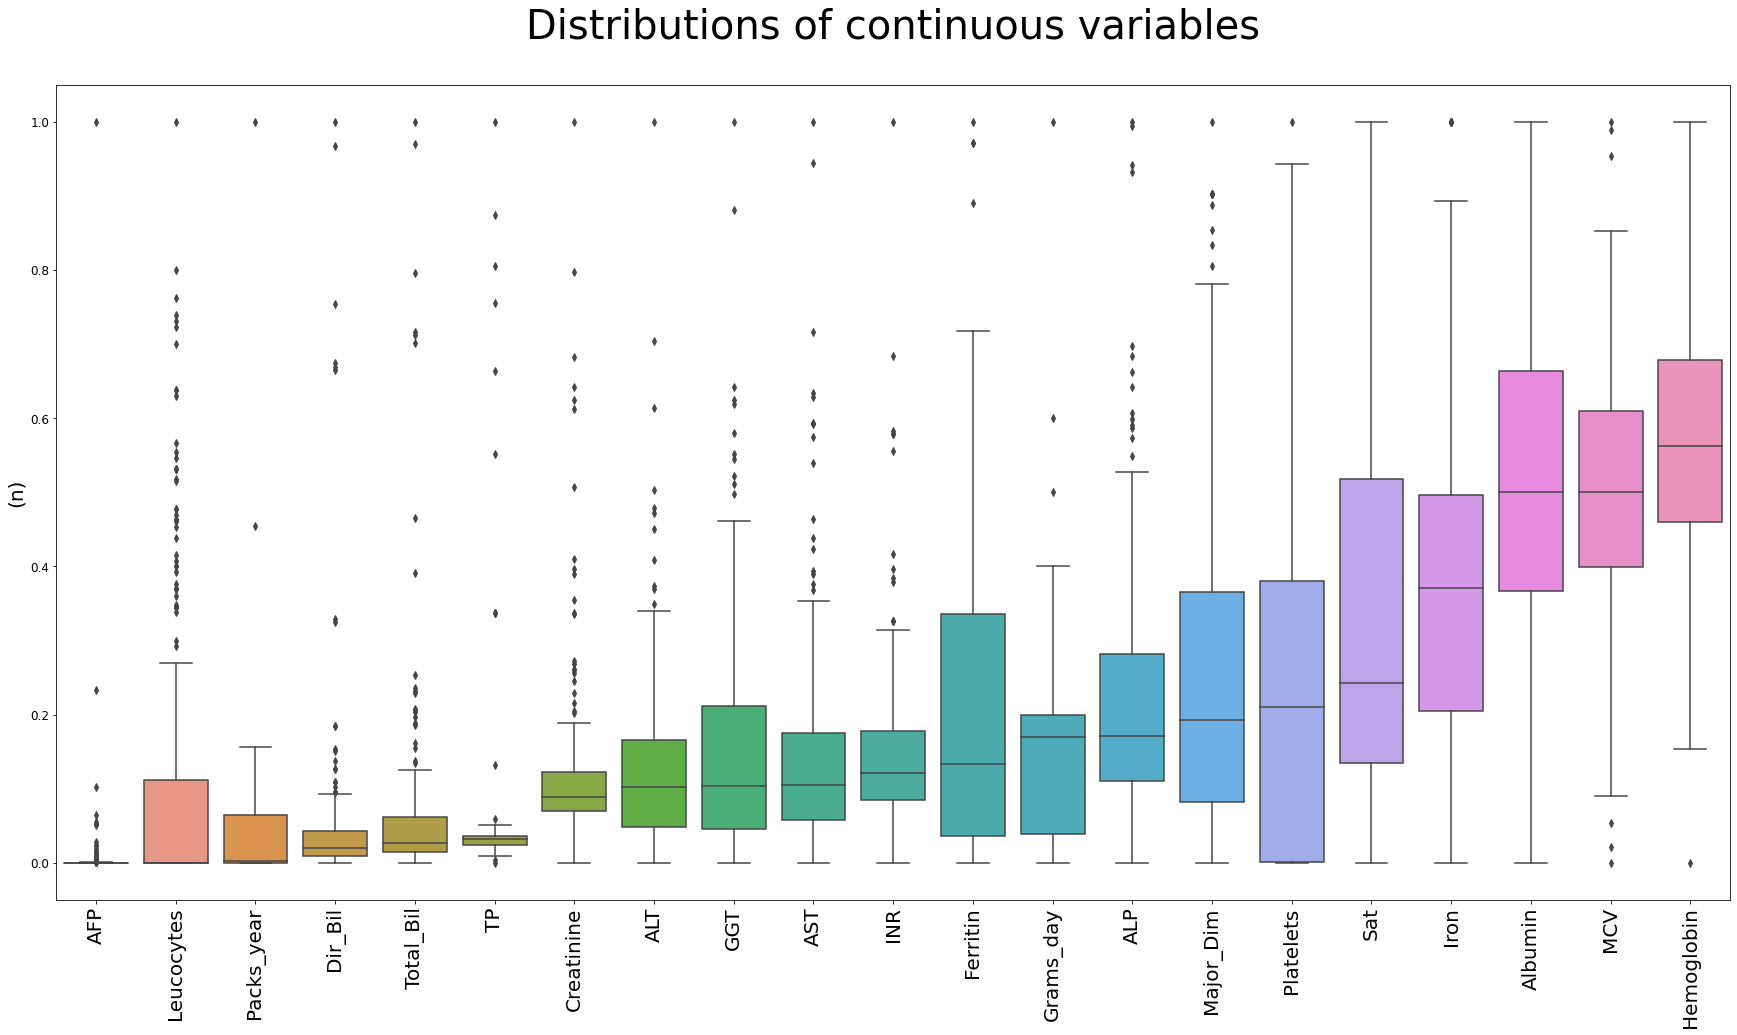

In [22]:
#import scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#create scaled dataframe
scaler = MinMaxScaler()
continuous_df_scaled = pd.DataFrame(scaler.fit_transform(continuous_df), columns=continuous_df.columns)

#create boxplot
plt.figure(figsize=(30,15))
sns.boxplot(data = continuous_df_scaled[continuous_df_scaled.median().sort_values().index.tolist()])
plt.xticks(fontsize=20, rotation = 90)
plt.yticks(fontsize=12)
plt.ylabel("(n)", fontsize = 20)
plt.title('Distributions of continuous variables', fontsize = 40, y = 1.05, x = 0.5)

#show plot
plt.show()

The box chart shows the distribution of our continuous variables. `AFP`, `Leucocytes`, and `Packs_year` towards the left of the boxplot appear to have with most values heavily skewed towards 0. This eludes to potential geometric distributions instead of the normal. Continuing right along the chart, variable distributions appear to shift from the log-normal to normal. The classification algorithms we will be using do not assume that data is normally distributed, so we will not need to transform any data to account for skew.

There are numerous outliers towards the left-hand side of the plot. The boxplot determines outliers based on the normal distribution, so outliers for non-normally distributed variables may be inaccurate.

**Integer variables**

Let's look at the distribution of integer variables:

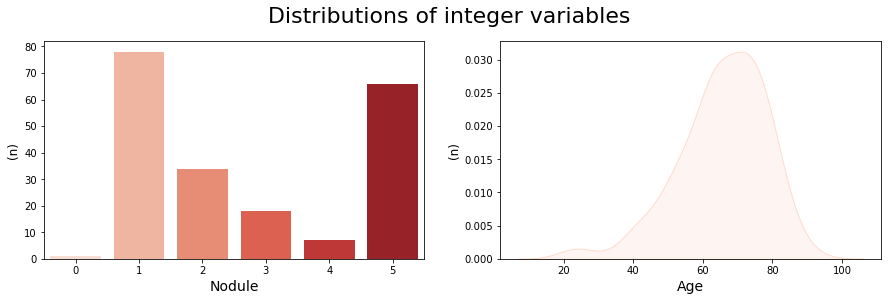

In [23]:
#create plot area
f, axes = plt.subplots(1, 2)
f.set_size_inches(15, 4)
plt.suptitle('Distributions of integer variables', y  = 1, fontsize = 22)

#create Nodule plot
ax1 = f.add_subplot(sns.countplot(x = df['Nodule'],ax=axes[0]))
ax1.set_ylabel('(n)', fontsize = 12)
ax1.set_xlabel('Nodule', fontsize = 14)

#create Age plot
ax2 = f.add_subplot(sns.kdeplot(x = integer_df['Age'], shade = True, ax=axes[1], legend=False))
ax2.set_ylabel('(n)', fontsize = 12)
ax2.set_xlabel('Age', fontsize = 14)

#show plots
plt.show()

The KDEplot shows `Age` to follow a nearly-normal distribution, with a slight left skew. The countplot shows ages to vary between 16 - 100 years, with a peak around 65~ years. `Nodule` shows a categorical distribution, with nodules 1 and 5 being the most prevalent.

**Dependent variable**

Let's look a the dependent variable `Class`:

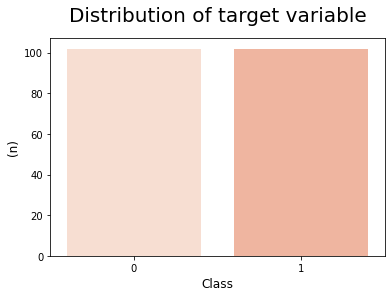

In [24]:
#create countplot
ax = sns.countplot(x = df['Class'])
ax.set_ylabel('(n)', fontsize = 12)
ax.set_xlabel('Class', fontsize = 12)
plt.title('Distribution of target variable', fontsize = 20, y = 1.05, x = 0.5)

#show plot
plt.show()

The plot shows there is a perfectly even split between patients who survived (102) and died (102) in our dataset.

## 3. Data preparation

Let's split and scale our independent variables and assign our dependent variable:

In [25]:
#import package
from sklearn.preprocessing import StandardScaler

#assign variables
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df), columns=df.columns) #scales categorical data
X = X.drop(columns = 'Class')
y = df['Class']

#show df shapes
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (204, 49)
y shape:  (204,)


**Scoring function**

We will assess features by creating two datasets: a control set containing the independent variables, a test set containing independent variables plus the altered features. The datasets will be run through a series of classifiers and model performance will be assessed by cross-validation under different scoring metrics. Comparing performance between models can be used to infer the strength of altered features. 

A collection of machine learning algorithms will be used to classify data: LinearSVC, GaussianNB, RandomForestClassifier, SVC, AdaBoostClassifier, and LogisticRegression. I won't go into detail on how each of these algorithms functions, but you can read the overview for each model on [Sklearn's website](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

The Receiver operating characteristic (ROC) scoring metric will be used to evaluate our models. I prefer the ROC score metric over a standard accuracy score for binary classification problems as it considers false positives rates as well as the true positive rate. Further details on the ROC scores can be viewed [here](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

Traditional test/train splits on small datasets can lead to bias accuracy scores. Given our relatively small sample size of 204, we will employ a K-fold cross-validation strategy to assess model accuracy. Cross-validation shuffles data into K number of groups. One group is taken as a test data set and the remaining groups are used to train the model. Model performance is logged and then the process is repeated until an averaged accuracy score is achieved. More information on K-fold cross-validation can be found [here](https://machinelearningmastery.com/k-fold-cross-validation/)


Let's create our function to compare datasets: 

In [26]:
def score_comp(X, X_mod, y):
    """
    Compares dataset performance with different classifiers using roc_auc and nMSE scores
    """

    #import modules
    import numpy as np
    from sklearn.svm import LinearSVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import RepeatedStratifiedKFold
   
    #specify models
    logR = LogisticRegression(C = 10, max_iter = 1000000, solver = 'saga', random_state = 42)
    linSVC = LinearSVC(max_iter = 1000000,  random_state = 42)
    ranF = RandomForestClassifier(n_estimators=1000, random_state = 42)
    mSVC = SVC(random_state = 42)
    adaB = AdaBoostClassifier(random_state = 42)
    
    #create tag lists
    models = [logR, linSVC, ranF, mSVC, adaB]
    model_tags = ['logR', 'linSVC', 'ranF', 'mSVC', 'adaB']
    test_tags = ['X_ROC_AUC', 'X_mod_ROC_AUC']
    cv_fold_q = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42) #faster function for testing
    cv_fold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 10, random_state = 42)
    
    
    #create target lists
    ROC = []
    ROC_mod = []
    
    #create test train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_mod_train, X_mod_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.15, random_state=42)
    
    #start loop
    for model in models:
        #append scores to target lists
        
        #X fit
        model.fit(X_train, y_train)
        ROC.append(cross_validate(model, X_test, y_test, scoring = 'roc_auc', cv = cv_fold_q, n_jobs = -1)['test_score'].mean())
        
        #X_mod fit
        model.fit(X_mod_train, y_train)
        ROC_mod.append(cross_validate(model, X_mod_test, y_test, scoring = 'roc_auc', cv = cv_fold_q, n_jobs = -1)['test_score'].mean())
    
    #build df using target and tag lists
    df = pd.DataFrame([ROC, ROC_mod]).T
    df.columns = test_tags
    df.index = model_tags
    return df

## 4. Feature engineering

Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models. We will employ three techniques to optimize our data: rounding, bivariate features, and polynomial features. Any variables displaying extreme collinearity (>0.95) will be dropped as they reduce the precision of the estimate coefficients - weakening the statistical power of regression models. 

**Creating Bivariates:**

Next, let's create bivariates using the ‘combinations’ method from itertools library. The top 5 performing bivariates will be added to our model. We will use a Logistic regression classifier with saga solver to select bivariates. Saga solver provides a dynamic regularization penalty which reduces the coefficients of highly correlated variables which helps eliminate redundant features. Models will be trained on data frames with/without the selected bivariates and both will have their performance evaluated:

In [27]:
#assign subset variable

#import modules
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

#assign classifier
clf = LogisticRegression(C = 1, solver = 'saga', max_iter = 10000, random_state = 42)#algorithm produces highest scoring model
cv_fold_q = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)
cv_fold = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state = 42)

#create list of combinations
columns_list = X.columns
interactions = list(combinations(columns_list, 2))

#score combinations in the df with logistic regression
scores = []
for interaction in interactions:
    X['int']  = (X[list(interaction)[0]] * X[list(interaction)[1]])
    scores.append(cross_validate(clf, X, y, scoring = 'roc_auc', cv = cv_fold_q, n_jobs = -1)['test_score'].mean())

#show high performing variables
scores = pd.Series(scores)
biv_idx = scores.sort_values(ascending=False).head(5).index.tolist()
top_biv = pd.Series(interactions)[biv_idx]
top_biv = [list(x) for x in top_biv.values]

#collect vals for bivs
biv_values = []
cols = []
for biv in top_biv:
    biv_values.append(X[biv[0]] * X[biv[1]])
    cols.append(biv[0]+'_x_'+biv[1])

#create df for bivs    
continuous_biv = pd.DataFrame(biv_values).T
continuous_biv.columns = cols

#transform data
X = X.drop(columns = ['int'])
X_mod = pd.concat([X, continuous_biv], axis = 1)
X_mod = pd.DataFrame(scaler.fit_transform(X_mod), columns=X_mod.columns)

#compare scores
print("Bivariate features selected: ", cols)
score_comp(X, X_mod, y)

Bivariate features selected:  ['Smoking_x_Age', 'Age_x_Nodule', 'Alcohol_x_Obesity', 'PHT_x_Albumin', 'ALT_x_AST']


,X_ROC_AUC,X_mod_ROC_AUC
logR,0.60,0.750
linSVC,0.60,0.700
ranF,0.60,0.775
mSVC,0.75,0.850
adaB,0.70,0.850


Our score comparisons show the addition of bivariates improves ROC scores across all models.

**Polynomials**

Another option for new features is increasing the power of a single variable. Let's see whether the addition of polynomial variables (including our bivariate combinations) can improve model performance:

In [28]:
#import module
from sklearn.model_selection import cross_validate

#include dataframe with bivariates
X = X_mod

#assign classifier
clf = LogisticRegression(max_iter = 100000, verbose = 0, solver = 'saga', random_state = 42)#performs the best

#generate comparison score
clf.fit(X, y)
comp_score  = cross_validate(clf, X, y, scoring = 'roc_auc', cv = cv_fold_q, n_jobs = -1)['test_score'].mean()

   
#create for loop
var = []
for feature in X.columns:
       for p in range(2, 5):
            X_poly = X
            X_poly['sq'] = X_poly[feature].values ** p
            clf.fit(X_poly, y)
            if cross_validate(clf, X, y, scoring = 'roc_auc', cv = cv_fold, n_jobs = -1)['test_score'].mean() > comp_score:
                var.append([feature, p, clf.score(X_poly, y)])
            else:
                pass

#create df with top polynomials
poly_scores = pd.DataFrame(var, columns = ['var','power','score']).sort_values(by = ['score','var'], ascending=False)
poly_df  = poly_scores.sort_values(by=['score','var'], ascending = False)
poly_top = poly_df.drop_duplicates(subset = 'var').head(5)

#create df with new variables
poly_cols = []
poly_trans = []
for var, power in zip(poly_top['var'], poly_top['power']):
    poly_trans.append(X[var] ** power)
    poly_cols.append(var+'^'+str(power))

#create dataframe
poly_df = pd.DataFrame(poly_trans).T
poly_df.columns =  poly_cols

#transform data
X = X.drop(columns = ['sq'])
X_mod = pd.concat([X, poly_df], axis = 1)
X_mod = pd.DataFrame(scaler.fit_transform(X_mod), columns=X_mod.columns)

#compare scores
print("Selected polynomials: ", poly_cols)
score_comp(X, X_mod, y)

Selected polynomials:  ['PS^3', 'PHT_x_Albumin^3', 'GGT^2', 'ALP^2', 'Platelets^2']


,X_ROC_AUC,X_mod_ROC_AUC
logR,0.750,0.700
linSVC,0.700,0.700
ranF,0.775,0.725
mSVC,0.850,0.800
adaB,0.850,0.750


The addition of polynomials either matched or worsened the ROC scores across all algorithms. Another test on our naive data frame (excluding bivariate combinations) also yielded poor model performance. Polynomials will be dropped from our training data.

**Scaling & Rounding:**

When dealing with continuous numeric attributes (like proportions or percentages), it's not essential to have a high degree of specificity. A rounded variable may retain the same degree of predictive power as its unrounded equivalent. Rounded variables can reduce the computational cost of models and in some cases can even increase model performance. Hence, it often makes sense to round off these high-precision floats. Let's measure the impact of rounding our data:

In [29]:
#transform data
X_mod = X.round(4)

#compare scores
score_comp(X, X_mod, y)

,X_ROC_AUC,X_mod_ROC_AUC
logR,0.750,0.750
linSVC,0.700,0.700
ranF,0.775,0.775
mSVC,0.850,0.850
adaB,0.850,0.850


The table shows rounding has no negative consequence on our classifiers; we will round our data to improve training times.

## 5. Feature selection

Before we can tune our model we need to indentify the 'best' subset of features for a model. Let's create test/train variables:

In [30]:
#convert training data
X = X_mod

#split data into test/train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#show dataframe shapes
print("X_train shape: ", X_train.shape)
print("X_test shape:  ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape:  ", y_test.shape)

X_train shape:  (173, 54)
X_test shape:   (31, 54)
y_train shape:  (173,)
y_test shape:   (31,)


### 5.1 Sequential feature selection

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d. We will use two approaches: forward feature selection and backward feature selection. Both are stepwise approaches which operate by sequentially adding/removing feature and evaluating model performance at each step. More details on sequential feature selection algorithms can be found [here](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).

**Forward feature selection**

Let's run our forward feature selection algorithm:

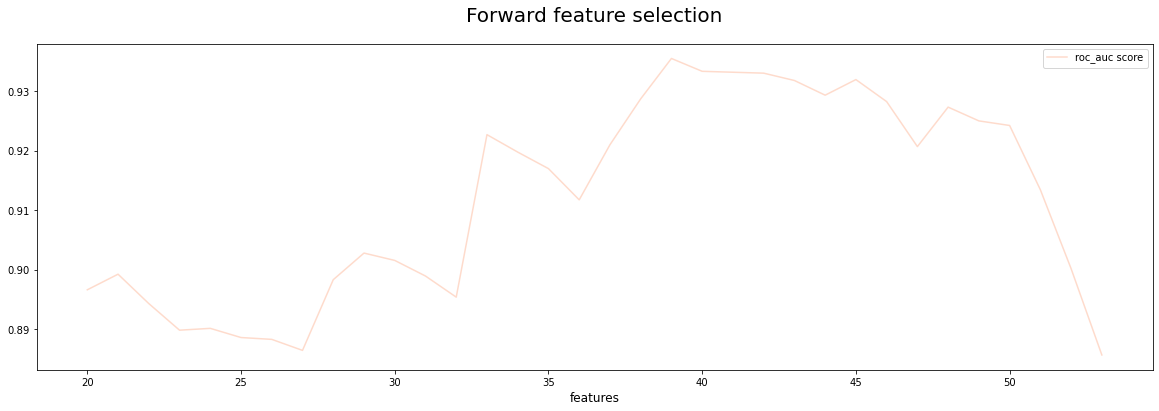

In [31]:
# import sequential feature selector
from mlxtend.feature_selection import SequentialFeatureSelector
import numpy as np

# import the algorithm you want to evaluate on your features.
from sklearn.svm import LinearSVC
#from sklearn.svm import SVC

#assign variables
k  = np.arange(20,len(X.columns)).tolist()
model = LinearSVC(max_iter = 10000, random_state = 42)
#model = mSVC = SVC(random_state = 42)
score = 'roc_auc'
cv_score = []
selected_features = []

#start loop
for value in k:
    
#create the SequentialFeatureSelector object, and configure the parameters.
    sfs = SequentialFeatureSelector(model, 
               k_features=value,
               forward=True, 
               floating=False,
               scoring=score,
               cv=cv_fold_q,
               n_jobs = -1,
               verbose = 0
               )

#fit the object to the training data and append scores
    sfs = sfs.fit(X_train, y_train)
    cv_score.append(sfs.k_score_)
    selected_features.append(X_train.columns[list(sfs.k_feature_idx_)])


#plot figure
ax = pd.DataFrame(cv_score,k,['roc_auc score']).plot.line(figsize = (20,6))
ax.set_xlabel('features', fontsize = 12)
plt.title('Forward feature selection', fontsize = 20, y = 1.05, x = 0.5)
plt.show()

The LinearSVC algorithm had the best perfomance for forward feature selection. We can see that model performance peaks at 38 features.

**Backward feature selection**

Let's run our backward feature selection algorithm:

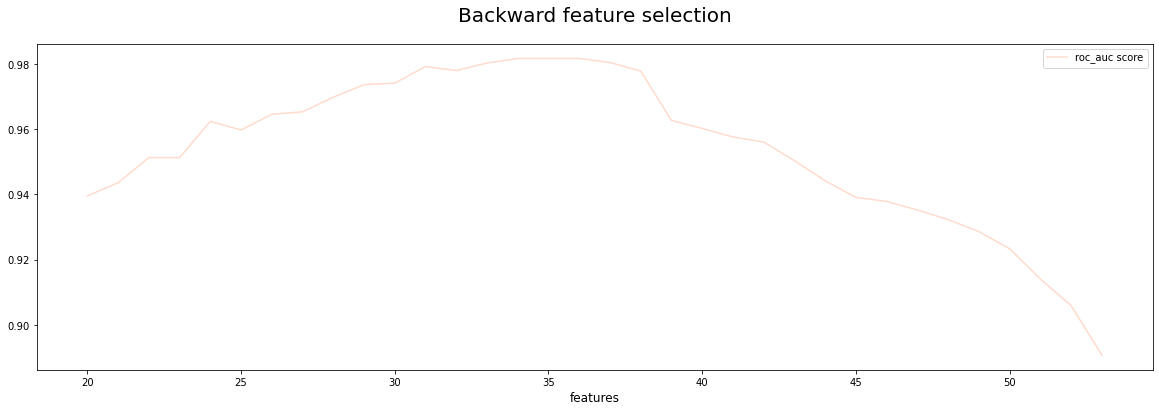

In [32]:
# import sequential feature selector
from mlxtend.feature_selection import SequentialFeatureSelector

# import the algorithm you want to evaluate on your features.
from sklearn.svm import LinearSVC

#assign variables
k  = np.arange(20,len(X.columns)).tolist()
model = LinearSVC(max_iter = 10000, random_state = 42)
score = 'roc_auc'
b_cv_score = []
b_selected_features = []

#start loop
for value in k:
    
#create the SequentialFeatureSelector object, and configure the parameters.
    bsfs = SequentialFeatureSelector(model, 
               k_features=value,
               forward=False, 
               floating=False,
               scoring=score,
               cv=cv_fold_q,
               n_jobs = -1,
               verbose = 0
               )

#fit the object to the training data and append scores
    bsfs = bsfs.fit(X_train, y_train)
    b_cv_score.append(bsfs.k_score_)
    b_selected_features.append(X_train.columns[list(bsfs.k_feature_idx_)])


#plot figure
ax = pd.DataFrame(b_cv_score,k,['roc_auc score']).plot.line(figsize = (20,6))
ax.set_xlabel('features', fontsize = 12)
plt.title('Backward feature selection', fontsize = 20, y = 1.05, x = 0.5)
plt.show()

Backward feature selection shows a similar trend as its forward selecting counterpart, although has a flatter peak ranging from 30-35 features and a better ROC score of 0.98. Let's use the highest performing model from our backward sequential feature selection model:

In [33]:
bsfs_df = pd.DataFrame([b_cv_score, b_selected_features]).T
bsfs_df = bsfs_df.reset_index()
bsfs_df.columns = ['no', 'score', 'features']
bsfs_features = bsfs_df.sort_values(by = 'score', ascending = False)['features'].tolist()[0]
print("Best performing subset: ", bsfs_features.tolist())

Best performing subset:  ['Symptoms', 'Alcohol', 'HBeAg', 'HCVAb', 'Cirrhosis', 'Endemic', 'Smoking', 'Obesity', 'Hemochro', 'AHT', 'CRI', 'HIV', 'NASH', 'Varices', 'Spleno', 'PVT', 'Age', 'Packs_year', 'Ascites', 'INR', 'AFP', 'MCV', 'Albumin', 'Total_Bil', 'ALT', 'AST', 'GGT', 'TP', 'Nodule', 'Major_Dim', 'Dir_Bil', 'Ferritin', 'Smoking_x_Age', 'Age_x_Nodule', 'PHT_x_Albumin', 'ALT_x_AST']


## 5. Classifier selection and hyper-parameter tuning

A hyperparameter is a value that is used to control the machine learning process. They are not to be confused with normal parameters, which are derived through model training. Choosing optimal hyperparameters for an algorithm can considerably improve model performance. You can read more on hyperparameter tuning [here](https://www.geeksforgeeks.org/hyperparameter-tuning/). We will use sklearn's GridSearchCV package to specify a range of hyperparameter across several classifiers to identify the optimal model. Let's reassign test/train variables based on the selected features:

In [34]:
#assign new test/train variables based on selected features
X_train = X_train[bsfs_features]
X_test = X_test[bsfs_features]

#print variable shapes
print("X train shape: ", X_train.shape)
print("X test shape:  ", X_test.shape)
print("y train shape: ", y_train.shape)
print("y test shape:  ", y_test.shape)

X train shape:  (173, 36)
X test shape:   (31, 36)
y train shape:  (173,)
y test shape:   (31,)


Now let's create a sklearn pipeline to find the best classifier and its parameters:

In [35]:
#import pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


#construct some pipelines
pipe_linSVC  = LinearSVC() #linSVC_penalty #loss #random_state #C #max_iter
pipe_logR = LogisticRegression() #logR_penalty #C #random_state #sovler #n_jobs #max_iter
pipe_ranF = RandomForestClassifier() #criterion #max_features #n_jobs #random_state
pipe_adaB = AdaBoostClassifier() #algorithm #random_state
pipe_mSVC = SVC() #C #kernel #random_state


#assign model params

##linSVC
linSVC_penalty = ['l1','l2']
loss = ['hinge','squared_hinge']
linSVC_max_iter = [1000000]

##logR
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag','saga']

##ranF
criterion = ['gini','entropy']
max_features = ['sqrt', 'log2', 'auto']

##adaB
algorithm = ['SAMME', 'SAMME.R']
decision_function_shape  = ['ovo', 'ovr']

##mSVC
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

##general
random_state = [42]
C = [1e-3, 1e-2, 1e-1, 1, 5, 10]
n_estimators = [100, 1000]
max_iter = [1000000]


#assign misc grid params

cv_fold = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)

score = 'roc_auc'


#set grid params
grid_params_linSVC = [{'loss': loss, 'random_state': random_state, 'C':C, 'max_iter':linSVC_max_iter}]
grid_params_logR = [{'solver':solver, 'random_state': random_state, 'C':C, 'max_iter':max_iter}]
grid_params_ranF = [{'criterion': criterion, 'max_features': max_features, 'random_state': random_state}]
grid_params_adaB = [{'algorithm': algorithm, 'random_state': random_state}]
grid_params_mSVC = [{'C':C, 'random_state': random_state }]

#construct grid searches
jobs = -1

gs_linSVC = GridSearchCV(estimator=pipe_linSVC,
                    param_grid=grid_params_linSVC,
                    scoring=score,
                    cv=cv_fold) 

gs_logR = GridSearchCV(estimator=pipe_logR,
                    param_grid=grid_params_logR,
                    scoring=score,
                    cv=cv_fold)

gs_ranF = GridSearchCV(estimator=pipe_ranF,
                    param_grid=grid_params_ranF,
                    scoring=score,
                    cv=cv_fold)

gs_adaB = GridSearchCV(estimator=pipe_adaB,
                    param_grid=grid_params_adaB,
                    scoring=score,
                    cv=cv_fold) 

gs_mSVC = GridSearchCV(estimator=pipe_mSVC,
                    param_grid=grid_params_mSVC,
                    scoring=score,
                    cv=cv_fold) 

#list of pipelines for ease of iteration
grids = [gs_linSVC, gs_logR, gs_ranF, gs_adaB, gs_mSVC]


# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'linSVC', 1: 'logR', 2:'ranF',3:'adaB', 4:'mSVC'}
acc_scores = []
dev_scores = []



print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print("Best CV params: %s" % gs.best_params_)
    # Best training data accuracy
    print("Best model roc_auc train value: %.5f" % gs.best_score_)
    
    #cross validate
    cv_out = cross_validate(gs, X_test, y_test, scoring = 'roc_auc', cv = cv_fold, n_jobs = -1)
    print("Best model roc_auc mean test value: ", cv_out['test_score'].mean())
    print("Best model roc_auc test stdev: ", cv_out['test_score'].std())
    
    #append to list for graph
    acc_scores.append(cv_out['test_score'].mean())
    dev_scores.append(cv_out['test_score'].std())

Performing model optimizations...

Estimator: linSVC
Best CV params: {'C': 1, 'loss': 'squared_hinge', 'max_iter': 1000000, 'random_state': 42}
Best model roc_auc train value: 0.98164
Best model roc_auc mean test value:  0.8
Best model roc_auc test stdev:  0.33166247903554

Estimator: logR
Best CV params: {'C': 10, 'max_iter': 1000000, 'random_state': 42, 'solver': 'newton-cg'}
Best model roc_auc train value: 0.97006
Best model roc_auc mean test value:  0.725
Best model roc_auc test stdev:  0.325

Estimator: ranF
Best CV params: {'criterion': 'entropy', 'max_features': 'log2', 'random_state': 42}
Best model roc_auc train value: 0.90147
Best model roc_auc mean test value:  0.8
Best model roc_auc test stdev:  0.24494897427831783

Estimator: adaB
Best CV params: {'algorithm': 'SAMME', 'random_state': 42}
Best model roc_auc train value: 0.86744
Best model roc_auc mean test value:  0.7
Best model roc_auc test stdev:  0.33166247903554

Estimator: mSVC
Best CV params: {'C': 5, 'random_state':

We can see the performance of our optimized models is fairly consistent with the results seen whilst conducting our feature evaluation. mSVC model with a 'C' value of 5 boasted the highest ROC score of 0.93981 on the cross-validated training data and 0.9 on the cross-validated test data and the lowest standard deviation score of 0.2. Let's visualise the test results in an error plot:

In [43]:
#create pd dataframe
alg_list = ['linSVC','logR','ranF','adaB', 'mSVC']
sup_df = pd.DataFrame([acc_scores, dev_scores])
sup_df.columns = alg_list
sup_df.index = ['acc', 'st_dev']
sup_df = sup_df.transpose()

#create errorplot
fig, ax = plt.subplots(figsize=(20, 6))
ax = plt.errorbar(sup_df.index, sup_df.acc, yerr=sup_df.st_dev, marker='s', mec='pink', ms=5, mew=4, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0,)
plt.ylim([0, 1])
plt.title('Supervised models test mean score & st dev', fontsize = 20, y = 1.05, x = 0.5)
plt.show()

ValueError: Length mismatch: Expected axis has 6 elements, new values have 5 elements

The plot confirms that mSVC has a higher mean roc auc score and a smaller error range than the other supervised models.

## 6. Deep Learning Model

Deep learning is a form of unsupervised machine learning which mimics aspects of how the human brain processes data for decision making. Deep learning models comprise densely interconnected nodes arranged into layers. There are three different types of layers: input, hidden, and output. The input layer is used to feed raw data to the network, and it then communicated it to the hidden layers for processing. Relationships between nodes are calculated and results are produced in the output layer. MIT has posted an article that explains the history and general premise behind deep learning [here](https://news.mit.edu/2017/explained-neural-networks-deep-learning-0414).

Keras is a high-level library that uses a Tensor flow (or Theanos) backend to build and compute deep neural networks. We will be using Keras' model 'Sequential' for our project. Sequential is a simple feed-forward neural network that is suitable for our classification problem. In our model, we will be using the layer type 'Dense' for all three of our input, hidden and output layers. Dense layer types receive inputs from all neurons of their previous layer. They are "fully connected" layers. We will also regularize our model using dropout layers, with a dropout rate of 0.2.

Activation functions are equations that decide whether a neuron fires based on the summed weight of input. The rectified linear activation function (ReLU) outputs the summed weight from an input neuron if it's positive. We will use the ReLU activation function for its simplicity and recognized efficacy in feed-forward deep learning models. More on ReLU can be found [here](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/).

Loss functions evaluate how well specific algorithms model data. Large losses are indicative of a poor model. We will be using the 'binary_crossentropy' loss function. Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events. A more detailed description of binary cross-entropy can be read [here](https://machinelearningmastery.com/cross-entropy-for-machine-learning/).

Optimizers train the neural network by optimizing the loss function. We will be using the 'Adam' optimizer. In classical stochastic gradient descent, a single learning rate is maintained throughout the learning process. Adam combines two extensions of classical stochastic gradient descent (AdaGrad & RMSProp) to create an adaptive and more robust optimizer. More information about the Adam optimizer can be read [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

We will use ROC score cross-validation to be consistent with our supervised model evaluation.

Let's prepare the data for deep learning:

In [37]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from numpy import random


#assign scaler
scaler = MinMaxScaler()
random_state = random.randint(0,100)

# baseline model
def create_baseline():
    #create model
    model = Sequential()
    model.add(Dense(49, input_dim=49, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    #compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
    return model

#assign variables
k_folds = 10
test_size = 1/k_folds
roc_scores = []

#create loop
i = 0
print("Beginning training:")  
while i < 10:
    
    #shuffle dfs
    X = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)#scales categorical data
    y = X['Class']
    X = X.drop(columns = 'Class')

    #assign stratfied shuffle split
    sss = StratifiedShuffleSplit(n_splits = 10, random_state = random_state)
    sss.get_n_splits(X,y)
    
    #extract test/train indices
    train = []
    test =[]
    for train_index, test_index in sss.split(X, y):
        train.append(train_index)
        test.append(test_index)
    
    #melt list of indices
    train = [x for x in train for x in x]
    test = [x for x in test for x in x]
    
    #create test/train data
    X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]

    #create and fit model
    keras_model = create_baseline()
    keras_model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=0)
    

    #calculate true positive and false positive rates
    y_pred_keras = keras_model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

    #calculate roc_score
    auc_keras = auc(fpr_keras, tpr_keras)
    roc_scores.append(auc_keras)
    #print("model roc_auc test value ", i+1,": ", auc_keras)
    print("\nTraining model...",i*10,"% complete")
    i+=1

print("\nMean cross validation test roc_auc value: %.5f" % pd.Series(roc_scores).mean())
print("\nMean cross validation test std_dev value: %.5f" % pd.Series(roc_scores).std())
acc_scores.append( pd.Series(roc_scores).mean())
dev_scores.append(pd.Series(roc_scores).std())

Using TensorFlow backend.


Beginning training:

Training model... 0 % complete

Training model... 10 % complete

Training model... 20 % complete

Training model... 30 % complete

Training model... 40 % complete

Training model... 50 % complete

Training model... 60 % complete

Training model... 70 % complete

Training model... 80 % complete

Training model... 90 % complete

Mean cross validation test roc_auc value: 0.99437

Mean cross validation test std_dev value: 0.00906


The test scores show our deep learning model to have very high performance with a test roc_auc score of 0.989 with st_dev of only 0.022. Let's add the Sequential model to the error plot:

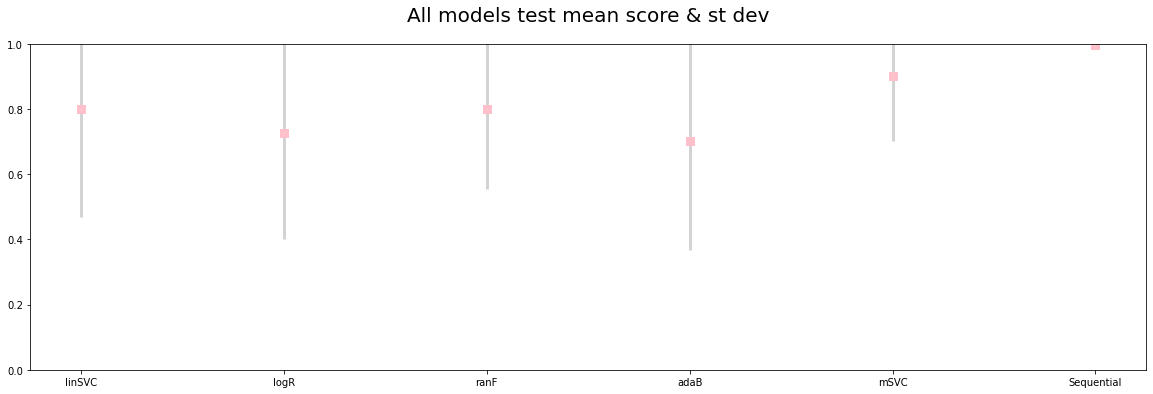

In [41]:
#create pd dataframe
alg_list = ['linSVC','logR','ranF','adaB', 'mSVC', 'Sequential']
sup_df = pd.DataFrame([acc_scores, dev_scores])
sup_df.columns = alg_list
sup_df.index = ['acc', 'st_dev']
sup_df = sup_df.transpose()

#create errorplot
fig, ax = plt.subplots(figsize=(20, 6))
ax = plt.errorbar(sup_df.index, sup_df.acc, yerr=sup_df.st_dev, marker='s', mec='pink', ms=5, mew=4, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0,)
plt.ylim([0, 1])
plt.title('All models test mean score & st dev', fontsize = 20, y = 1.05, x = 0.5)
plt.show()

We can see that the Sequential model has a better mean roc auc score and less standard deviation of scores than the supervised models.

## 7. Discussion

The project succeeded in creating two accurate models supervised and unsupervised models for predicting the long-term survivability of HCC patients using the HCC dataset. The unsupervised 'Sequential' model was the most accurate producing a cross-validated roc_auc score of 0.989 with a loss near 0.022. 

Characteristics of the HCC dataset removed the need for data cleansing but demanded consideration when training and validating models. The dataset was complete and no imputation/deletion was necessary to prepare data, improving model generalizability. However, the presence of different data types and distributions abstracted our understanding of the relationships between variables during the data exploration phase. The dataset's high dimensionality and small sample size necessitated the identification of feature subset. This reduced the likelihood of supervised models overfitting to the training data. Similarly, cross-validation was used during evaluation to account for variation arising from the small dataset.

After data cleansing, features were engineered to enhance the training potential of the dataset for supervised models. Logistic regression with 'saga' solver was utilized for assessing bivariate and polynomial performance. The addition of polynomials and scaled data had a negative and no effect on model performance respectively. Whereas the inclusion of bivariates improved model performance. High-performing bivariates seemed to form two groups. 'Smoking_x_Age' and 'Alcohol_x_Obesity' seemed to fit into the risk factors group. Wheras 'PHT_x_Albumin' and 'ALT_x_AST' are liver disease markers. The significance of bivariates was confirmed when all the bivariate were retained during feature subset selection. Further domain-specific research could help understand the significance between bivariate combinations.

Sequential feature selection was used to identify high-performing data subsets. The LinearSVC algorithm with backward feature selection produced the best subset of ~35 features. Initially, model performance improved as data dimensionality was reduced. This contradicted expectations that our models would overfit the higher dimensionality data. 

Following feature selection, we used Sklearn's GridSearchCV to select optimal hyperparameters for each algorithm and compare performance for supervised models. Although linearSVC and logistic regression models had higher performance on the training data, the mSVC model outperformed all algorithms on the test dataset, implying a more robust model. An unsupervised classification model was produced using Keras' Sequential. Optimal performance was achieved using four hidden layers, a batch size of 5 over 10 epochs. The deep-learning model produced a final cross-validated roc_auc score of 0.99382, with a std_dev value of 0.01049, outperforming all supervised models.

Despite the high performance of the Sequential model, a couple of limitations of the HCC dataset warrant investigation before this model could be considered fully robust. The HCC dataset collected information from one hospital in Portugal. Having all of our data sampled from one location may have created low sample diversity. Sample data with high homogeneity could be biologically unrepresentative and produce models which have poor out-of-sample performance. Follow-up experiments should aim to include data from different populations to increase the biodiversity of samples. This (in theory) would make a more robust model for predicting long-term survivability in HCC patients.

Another hurdle presented by the HCC dataset was its limited sample size. Although there is no specific measure of how many data points are required to train a model, a rough estimation often used is 10 * the degrees of freedom in the model. Applying this theory, we should have had at least 300 (30 * 10) data points to train our supervised model, and 490 (49 * 10) to train our unsupervised model. Given that our dataset only contained 204 data points, we fell short of the suggested sample size for both models. Despite trying to reduce model overfitting through feature selection in our supervised model, the inclusion of several hidden layers in our neural network, and cross-validation, further modeling using different data would be necessary to confirm model generalizability.

Overall, we successfully created an accurate model to predict the long-term survivability of liver cancer patients using the HCC data. However certain questions regarding the biodiversity and limited sample size HCC dataset require answering before any model could be used in a clinical setting.